<a href="https://colab.research.google.com/github/ElionMarku00/VQA-project/blob/main/VQA_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np
import math
import json
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

from collections import Counter

from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset,TensorDataset
from tqdm import tqdm


drive.mount('/content/drive', force_remount=True)


batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cuda')

In [ ]:
# !unzip -o '/content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO.zip' -d '/content/drive/MyDrive/deep learning labs/deep_learning/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_train2014/all_images/COCO_train2014_000000482157.jpg  
  inflating: /content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_train2014/all_images/COCO_train2014_000000482177.jpg  
  inflating: /content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_train2014/all_images/COCO_train2014_000000482191.jpg  
  inflating: /content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_train2014/all_images/COCO_train2014_000000482195.jpg  
  inflating: /content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_train2014/all_images/COCO_train2014_000000482223.jpg  
  inflating: /content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_train2014/all_images/COCO_train2014_000000482251.jpg  
  inflating: 

## Working with images:

In [ ]:
train_transforms = transforms.Compose([

                                #   transforms.RandomResizedCrop(224),
                                #  transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                #  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ])

val_transforms = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_pictures_dir = '/content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_train2014'
val_pictures_dir = '/content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/miniCOCO_val2014'

train_images_dataset = datasets.ImageFolder(train_pictures_dir, train_transforms)
val_images_dataset = datasets.ImageFolder(val_pictures_dir, val_transforms)

train_images_dataloader = DataLoader(train_images_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_images_dataloader = DataLoader(val_images_dataset, batch_size=100, shuffle=False, num_workers=2, pin_memory=True)

print(len(train_images_dataset))
print(len(val_images_dataset))


KeyboardInterrupt: 

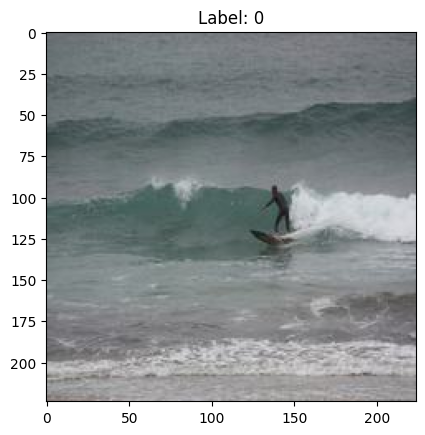

In [ ]:
# displaying random image from train_images_dataloader

images, labels = next(iter(train_images_dataloader))

# Select a random image from the batch
random_idx = random.randint(0, len(images) - 1)
image = images[random_idx]

# Convert the tensor to a NumPy array and transpose dimensions from (C, H, W) to (H, W, C)
image = image.numpy().transpose((1, 2, 0))

# Display the image using matplotlib
plt.imshow(image)
plt.title(f'Label: {labels[random_idx]}')
plt.show()

## Working directly with FEATURES:

In [ ]:

class NPZLoader(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = [os.path.join(path, file) for file in os.listdir(path)]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
      file_path = self.files[item]
      with np.load(file_path) as data:
          keys = data.files
          # print(f"Keys in {file_path}: {keys}")

          numpy_array = data['feat']

      torch_array = torch.from_numpy(numpy_array)
      if self.transform is not None:
          torch_array = self.transform(torch_array)
      # return keys, torch_array, 0
      return torch_array



    # def __getitem__(self, item):
    #     numpy_array = np.load(str(self.files[item]))['arr_0']



    #     torch_array = torch.from_numpy(numpy_array)
    #     if self.transform is not None:
    #         torch_array = self.transform(torch_array)
    #     return torch_array, 0


trainFeaturesDir = "/content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/picture features/trainFeatures"
train_picture_features = NPZLoader(trainFeaturesDir)
train_features_loaded = DataLoader(train_picture_features, batch_size=128, shuffle=True, num_workers=2, pin_memory=True) # NPZLoader is not iterable so a Dataloader is used with the data


valFeaturesDir = "/content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCO/miniCOCO/picture features/valFeatures"
val_picture_features =  NPZLoader(valFeaturesDir)
val_features_loaded =  DataLoader(val_picture_features,batch_size=100, shuffle=False, num_workers=2, pin_memory=True)


next(iter(train_picture_features))  # val_picture_features




tensor([[ 3.2233,  0.0760,  0.2498,  ...,  0.0304, 17.0168,  0.0000],
        [ 4.1171,  0.0264,  0.0274,  ...,  0.4809, 18.2155,  0.0000],
        [ 1.2811,  0.0000,  0.0000,  ...,  0.0000,  0.9914,  0.4697],
        ...,
        [ 2.4459,  0.0203,  0.0000,  ...,  0.0214,  2.0755,  0.0000],
        [ 0.3590,  0.0000,  0.0538,  ...,  0.0000,  4.0061,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  5.9012,  0.2075]])

# CNN for picture feature extraction



In [ ]:

class CNN(nn.Module):
    def __init__(self, increase_factor = 16):
        super().__init__()

        self.conv1 = nn.Conv2d(3, increase_factor, 3, 1)
        self.conv2 = nn.Conv2d(increase_factor, increase_factor * 2, 3, 1)
        self.conv3 = nn.Conv2d(increase_factor * 2, increase_factor * 3, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(increase_factor * 3 * 52 * 52, 64)  # Adjusted for the larger image size
        self.classifier = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):    # (N, 3, 224, 224)
        x = self.pool(F.relu(self.conv1(x)))   # (N, 42, 224, 224) --> pool --> (N, 42, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))   # (N, 84, 112, 112) --> pool --> (N, 84, 56, 56)
        x = F.relu(self.conv3(x))              # (N, 126, 56, 56)
        x = x.view(x.size(0), -1)              # Flatten the tensor: (N, 126*56*56)
        x = self.dropout(F.relu(self.fc(x)))   # (N, 64)

        # the classifier here is just used to test if the cnn is learning
        # x = self.classifier(x)                 # (N, 10)

        return x

In [ ]:
model = CNN().to(device)
random_input = torch.randn(1,3,224,224).to(device)
print(model(random_input).shape)

torch.Size([1, 10])


In [ ]:
# Define the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # should help increase training time

print_every = 300

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx,(inputs, targets) in enumerate(train_images_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        epoch_loss = train_loss/(batch_idx+1)
        epoch_acc = 100.*correct/total

        if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, len(train_images_dataloader),
                                                                                   epoch_loss, epoch_acc))




    scheduler.step()
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_images_dataloader)}, Accuracy: {100.*correct/total}%')

Epoch 0/10, Iter 0/192, Train Loss: 2.427, Train Accuracy: 0.000


In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    average_loss = test_loss / len(dataloader)
    accuracy = 100. * correct / total
    return average_loss, accuracy

  # Evaluate the model
test_loss, test_accuracy = evaluate_model(model, val_images_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Transformer Encoder to encode relationships among features

In [ ]:

class Patchify(nn.Module):

    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_channels = 3,
                              out_channels = embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)

    def forward(self, x):
        # print(x.shape)
        B, C, H, W = x.shape
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
        #  # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):

        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)


class ViT(nn.Module):
    def __init__(self,
                 num_patches,
                 embed_dim,
                 num_classes,
                 num_layers,
                 heads,
                 dropout):
        super().__init__()

        self.pos_encoding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.transformer = Transformer(embed_dim, num_layers, heads, dropout=dropout)
        # self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x is expected to be of shape (batch_size, num_patches, embed_dim)

        # Add positional encoding
        x = x + self.pos_encoding

        # Pass through the transformer
        x = self.transformer(x)

        # Average the outputs of all patches (or you could use the output of the [CLS] token, if present)
        # x = x.mean(dim=1)

        # Classification layer
        # x = self.classifier(x)
        return x

# class ViT(nn.Module):
#     def __init__(self,
#                 #  image_size,
#                  patch_size,
#                  num_classes,
#                  dim,
#                  num_layers,
#                  heads,
#                  dropout,
#                  max_patches=100
#                  ):
#         super().__init__()

#         # self.patchify = Patchify(image_size, patch_size, dim)
#         self.pos_encoding = nn.Parameter(torch.randn(1, max_patches, dim))
#         self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)
#         self.classifier = nn.Linear(dim, num_classes)

#     def forward(self, x):
#         x = self.patchify(x)  # (batch_size, N, dim)

#         # Slice pos_encoding to match the current number of patches
#         curr_pos_encoding = self.pos_encoding[:, :x.size(1), :]

#         # Expand pos_encoding along the batch dimension
#         curr_pos_encoding = curr_pos_encoding.expand(x.size(0), -1, -1)

#         x = x + curr_pos_encoding  # (batch_size, N, dim)
#         x = self.transformer(x)    # (batch_size, N, dim)
#         x = x.mean(1)              # (batch_size, dim)
#         x = self.classifier(x)
#         return x

In [ ]:
next(iter(train_picture_features)).shape

torch.Size([20, 2048])

In [ ]:
# model = ViT(
#             # image_size = 224,
#             patch_size = 4,
#             num_classes = 100,
#             dim = 2048,
#             num_layers = 3,
#             heads = 8,
#             dropout = 0.1).to(device)

model = ViT(
    num_patches=20,  # Number of patches (or the sequence length)
    embed_dim=2048,   # Embedding dimension
    num_classes=100,  # Number of output classes
    num_layers=3,     # Number of transformer layers
    heads=8,          # Number of attention heads
    dropout=0.1).to(device)


random_input = torch.randn(1,20,2048).to(device)
print(model(random_input).shape)

torch.Size([1, 20, 2048])


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Text(0, 0.5, 'learning rate')

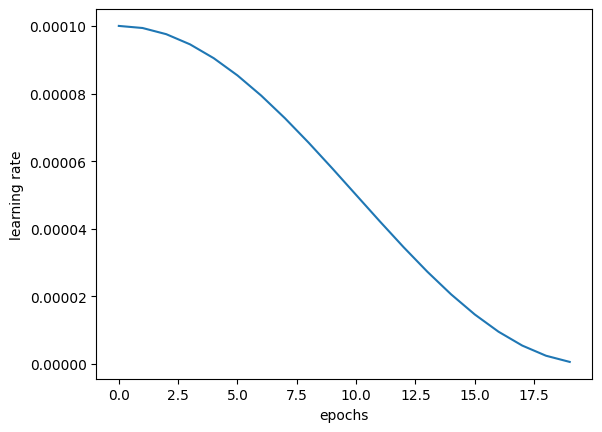

In [ ]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

lrs = []

for _ in range(epochs):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

plt.plot(lrs)
plt.xlabel('epochs')
plt.ylabel('learning rate')

In [ ]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss()

In [ ]:
print_every = 200
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, inputs in enumerate(train_features_loaded):
        inputs, targets = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        epoch_loss = train_loss/(batch_idx+1)
        epoch_acc = 100.*correct/total

        if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, len(train_features_loaded),
                                                                                   epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [ ]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(val_features_loaded)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    loss = test_loss/(batch_idx+1)
    print('Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(acc, loss))
    return acc

In [ ]:
best_acc = 0

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    scheduler.step()
    acc = test()
    state = {'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch}
    if acc > best_acc:
        torch.save(state, 'model.pth')
        best_acc = acc

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 141, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [27, 2048] at entry 0 and [21, 2048] at entry 1


# Combined Vision Model

In [ ]:
class CombinedVisionModel(nn.Module):
    def __init__(self, num_classes, image_dim, transformer_dim, num_layers, heads, dropout, max_patches):
        super().__init__()
        self.cnn = CNN()  # Ensure CNN's output matches input requirements for ViT
        self.vit = ViT(
            num_classes=num_classes,
            dim=transformer_dim,
            num_layers=num_layers,
            heads=heads,
            dropout=dropout,
            max_patches=max_patches
        )

    def forward(self, x):
        x = self.cnn(x)  # Get features from CNN
        x = self.vit(x)  # Pass features to Vision Transformer
        return x

In [ ]:
combined_model = CombinedVisionModel(
    num_classes=10,  # Set according to your task
    image_dim=768,  # Must match ViT dimensions
    transformer_dim=768,  # Must match CNN and ViT dimensions
    num_layers=12,
    heads=12,
    dropout=0.1,
    max_patches=196  # Example value, adjust based on patch size
).to(device)

# Create dummy data
dummy_images = torch.randn(4, 3, 224, 224).to(device)  # Batch of 4 images

# Test the combined model
with torch.no_grad():
    combined_model.eval()
    outputs = combined_model(dummy_images)
    print(outputs.shape)  # Should match [batch_size, num_classes]

# LSTM and question encoding

In [ ]:
# Loading the COCO training dataset
# train_set = json.load(open("/content/drive/MyDrive/deep data/miniCOCOtrain.json"))
train_set = json.load(open("/content/drive/MyDrive/deep learning labs/deep_learning/data/miniCOCOtrain.json"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/deep data/miniCOCOtrain.json'

In [ ]:
# Create an empty Counter object to count occurrences of answers
answer_counter = Counter()
for item in train_set.values():
    for ans in item['answers']:
      # Increment the count for the specific answer in the Counter
        answer_counter[ans] += 1
# Find the number of unique answers
num_unique_answers = len(answer_counter)
print(f"Number of unique answers: {num_unique_answers}")

# Get the top 10 most frequent answers
top_answers = answer_counter.most_common(10)
print(f"Top 10 most frequent answers: {top_answers}")

# Plot the top 10 answers
labels, values = zip(*top_answers)
indexes = range(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Answers')
plt.title('Top 10 Most Frequent Answers')
plt.show()

In [ ]:
# Define a minimum word frequency threshold
min_word_freq = 3
# Create a list of words that appear more than 'min_word_freq'
words = [w for w in answer_counter.keys() if answer_counter[w] > min_word_freq]
# Create a mapping
word_map_ans = {k: v + 1 for v, k in enumerate(words)}
word_map_ans['<unk>'] = len(word_map_ans) + 1
word_map_ans['<start>'] = len(word_map_ans) + 1
word_map_ans['<end>'] = len(word_map_ans) + 1
word_map_ans['<pad>'] = 0
# Create a reverse mapping
rev_word_map = {v: k for k, v in word_map_ans.items()}

print("Total words are: {}".format(len(word_map_ans)))

In [ ]:
# Create an empty Counter object to count occurrences of questions
word_freq = Counter()
for query in train_set.values():
    question = query['question']
    query_words = question.lower().replace('?', '').split()
    word_freq.update(query_words)

In [ ]:
# lets have a look at the top 10 words
top_words = [word for word, count in word_freq.most_common(15)]
top_frequencies = [count for word, count in word_freq.most_common(15)]

# Create a bar plot for the top 5 words
plt.figure(figsize=(10,4))
plt.bar(top_words, top_frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Words Frequency Histogram")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
min_word_freq = 3
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0
rev_word_map = {v: k for k, v in word_map.items()}

print("Total words are: {}".format(len(word_map)))
# print(word_map)

# Data encoding
Before passing data to LSTM, we encode the question series.

In [ ]:
encoded_dataset = []

for entry in train_set.values():
    print(entry['image_id'])
    # Process question
    question = entry['question'].lower().replace('?', '').split()
    # The longest question was 22 in the current dataset
    question = question[:22]
    encoded_question = [word_map.get(word, word_map['<unk>']) for word in question]
    encoded_question += [word_map['<pad>']] * (22 - len(question))

    # Process answer
    most_frequent_answer = Counter(entry['answers']).most_common(1)[0][0]
    encoded_answer = word_map_ans.get(most_frequent_answer, word_map_ans['<unk>'])

    # Add to new dataset
    encoded_dataset.append({'question': encoded_question, 'answer': encoded_answer})

# Creating dataset
change here to have image feature vector too

In [ ]:
print(encoded_dataset[-100])
print(len(encoded_dataset))

## **LSTM class**

LSTM class implemented in WPO that can be used as an alternative to the default nn.LSTM

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_sz, hidden_sz):

        super(LSTM, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        #c_t: new memory (the new memory)
        self.W_c = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #i_t: input gate (how much to take from the new memory)
        self.W_i = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #f_t: forget gate (how much to forget from the old memory)
        self.W_f = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #o_t: output gate (how much to take from the new memory to represent the output)
        self.W_o = nn.Linear(input_sz + hidden_sz, hidden_sz)

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        # initialize h_t and c_t to zeros
        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device),
                    torch.zeros(batch_size,self.hidden_size).to(device))

        hidden_states = []

        for t in range(seq_len):
            # get the input at the current timestep
            x_t = x[:, t, :]

            # run the LSTM Cell
            common_input = torch.cat([x_t, h_t], dim = -1)

            new_c = torch.tanh(self.W_c(common_input))
            i_t = torch.sigmoid(self.W_i(common_input))
            f_t = torch.sigmoid(self.W_f(common_input))
            c_t = f_t * c_t + i_t * new_c

            o_t = torch.sigmoid(self.W_o(common_input))
            h_t = o_t * torch.tanh(c_t)

            # save the hidden states in a list
            hidden_states.append(h_t.unsqueeze(1))

        hidden_states = torch.cat(hidden_states, dim = 1)

        return hidden_states

## **Transformer**

First step is Positional Encoding

###Multi head attestation

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500, device=torch.device('cpu')):
        super(PositionalEncoding, self).__init__()
        self.device = device

        # Create a long enough 'pe' matrix for positional encoding
        pe = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float().to(device) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        # Register 'pe' as a buffer that is not a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to each token
        x = x + self.pe[:x.size(0), :]
        return x

# Co-developed by Chat-GPT
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0  # Ensure the heads can be evenly distributed

        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, d_model)

    def split_into_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.split_into_heads(self.wq(q), batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_into_heads(self.wk(k), batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_into_heads(self.wv(v), batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Scaled dot-product attention
        matmul_qk = torch.matmul(q, k.transpose(-2, -1))  # (batch_size, num_heads, seq_len_q, seq_len_k)
        d_k = torch.tensor(self.depth, dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(d_k)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = F.softmax(scaled_attention_logits, dim=-1)  # (batch_size, num_heads, seq_len_q, seq_len_k)
        attention_weights = self.dropout(attention_weights)

        output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len_q, depth)

        # Concatenation of heads
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)

        # Final linear layer
        output = self.fc(output)

        return output

# Co-developed by chat-GPT for comments
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        Initializes the FeedForward network.

        Args:
            d_model (int): The dimension of the input and output.
            d_ff (int): The dimension of the hidden layer.
            dropout (float): Dropout rate.
        """
        super(FeedForward, self).__init__()

        # First fully connected layer
        self.fc1 = nn.Linear(d_model, d_ff)

        # Second fully connected layer that returns to d_model size
        self.fc2 = nn.Linear(d_ff, d_model)

        # Activation function
        self.relu = nn.ReLU()

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        The forward pass of the FeedForward network.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor.
        """
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

### **Transformer Encoder Layer**
We will combine all the components into one class

In [ ]:
# single layer in the Transformer encoder
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # Multi-Head Attention
        attention_output = self.multi_head_attention(src, src, src)
        # Apply layer normalization and dropout
        src = src + self.dropout(attention_output)
        src = self.norm1(src)

        # Feed-Forward Network
        ff_output = self.feed_forward(src)
        # Apply layer normalization and dropout
        src = src + self.dropout(ff_output)
        src = self.norm2(src)

        return src

# stacks multiple TransformerEncoderLayers to create a complete encoder
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        # list of TransformerEncoderLayer instances
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)

        return src


### **Net class**


In [ ]:
class Net(nn.Module):

    def __init__(self, input_embedding_size, hidden_size, num_layers, num_heads, d_ff, max_seq_length, pooling_type='last_hidden_state'):
        super().__init__()
        self.embedding = nn.Embedding(len(word_map), input_embedding_size)
        self.positional_encoding = PositionalEncoding(input_embedding_size, max_seq_length)
        # Changing to our LSTM implemnation if needed
        self.lstm = LSTM(input_embedding_size, hidden_size)
        # self.lstm = nn.LSTM(input_size=input_embedding_size,
        #                     hidden_size=hidden_size,
        #                     num_layers=1,
        #                     batch_first=True)

        # Transformer Encoder
        self.transformer_encoder = TransformerEncoder(num_layers, hidden_size, num_heads, d_ff)

        self.pooling_type = pooling_type

    def forward(self, x):
        # Embedding
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # LSTM
        # Changing to our LSTM implemnation if needed
        # hidden_state = self.lstm(x)
        lstm_out, (hidden_state, cell_state) = self.lstm(x)
        # Apply Positional Encoding
        encoded_state = self.positional_encoding(hidden_state)

        # Transformer Encoder
        transformer_output = self.transformer_encoder(encoded_state)

        return transformer_output


####**Training**

In [ ]:

# Convert encoded_dataset to tensors
questions = torch.tensor([item['question'] for item in encoded_dataset])
answers = torch.tensor([item['answer'] for item in encoded_dataset])

# Create a TensorDataset
dataset = TensorDataset(questions, answers)

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


input_embedding_size = 100  # Example value
hidden_size = 128  # Example value
num_layers = 6  # Number of Transformer encoder layers
num_heads = 8  # Number of heads in Multi-Head Attention
d_ff = 512  # Dimension of Feed-Forward network
# ------------------------
max_seq_length = 32  # Assuming this is the max sequence length in your dataset

# Initialize the network with the new parameters
net = Net(input_embedding_size, hidden_size, num_layers, num_heads, d_ff, max_seq_length)
net = net.to(device)

# Training Loop
for epoch in range(10):
    for batch in data_loader:
        # input_data = batch[0].to(device)
        # output = net(input_data)  # Now 'output' is the output from the Transformer encoder
        question_data, answer_data = batch
        question_data = question_data.to(device)
        answer_data = answer_data.to(device)  # You might use this for calculating the loss

        output = net(question_data)
        # Perform any additional operations on 'output' as needed
# to be used later##############################################
        # for epoch in range(10):
        #     for batch in data_loader:
        #         question_data, answer_data = batch
        #         question_data, answer_data = question_data.to(device), answer_data.to(device)

        #         # Zero the parameter gradients
        #         optimizer.zero_grad()

        #         # Forward pass
        #         outputs = net(question_data)

        #         # Compute loss
        #         loss = criterion(outputs, answer_data)

        #         # Backward pass and optimize
        #         loss.backward()
        #         optimizer.step()

        #         # ...

# Optional: Print the shape of the last batch's output
print("Shape of the last output:", output.shape)


In [ ]:
print(output[-1])

In [ ]:
pooled_output = output.mean(dim=1)
print("Shape of the last output:", pooled_output.shape)

In [ ]:
print(pooled_output)

Creating the dataset of feature vector and label(answers) to be used for classifier

In [ ]:
class VQADataset(Dataset):
    def __init__(self, feature_vectors, answers_list, word_map_ans):
        self.feature_vectors = feature_vectors
        self.answers_list = answers_list
        self.word_map_ans = word_map_ans

    def __getitem__(self, idx):
        feature_vector = self.feature_vectors[idx]

        # Get the most frequent answer
        answer_occurrences = Counter(self.answers_list[idx])
        most_frequent_answer = answer_occurrences.most_common(1)[0][0]

        # Convert the answer to its corresponding index, use '<unk>' for unknown answers
        label_idx = self.word_map_ans.get(most_frequent_answer, self.word_map_ans['<unk>'])

        return feature_vector, label_idx

    def __len__(self):
        return len(self.feature_vectors)

# Example usage
feature_vectors = [torch.tensor([1.0, 2.0, 3.0]), torch.tensor([4.0, 5.0, 6.0])]
answers_list = [['yes', 'no', 'no', 'yes'], ['maybe', 'yes', 'maybe', 'maybe']]
word_map_ans = {'yes': 1, 'no': 2, 'maybe': 3, '<unk>': 4, '<pad>': 0}  # example word map

vqa_dataset = VQADataset(feature_vectors, answers_list, word_map_ans)
sample_feature_vector, sample_label_idx = vqa_dataset[0]

print("Feature Vector:", sample_feature_vector)
print("Label Index:", sample_label_idx)


Here is the combined LSTM and transformer encoder. It's an early version but it works so other parts can continue for now as I improve it.

##**MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

As I undertand, we need to create the dataset for this part. in this dataset the value is the fusion vector representing both visual and textual features and the label is answer. So we first need to create the dataset of labels like we did for the questions.

## Fusion


# FINAL VQA MODEL

In [ ]:
class VQAFinal(nn.Module):
    def __init__(self, num_classes, image_dim, text_dim, transformer_dim, num_layers, heads, dropout, max_patches, max_seq_len):
        super().__init__()
        self.image_model = CombinedVisionModel(
            num_classes=num_classes,
            dim=transformer_dim,
            num_layers=num_layers,
            heads=heads,
            dropout=dropout,
            max_patches=max_patches
        )
        self.text_model = Net(
            vocab_size=10000,  # Example vocab size
            embed_dim=text_dim,
            hidden_dim=512,
            num_layers=2,
            transformer_dim=transformer_dim,
            transformer_layers=num_layers,
            transformer_heads=heads,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.mlp = MLP(
          input_dim=transformer_dim * 2,  # Combined dimension from image and text features
          hidden_dim=512,
          output_dim=num_classes
        )
        self.fc = nn.Linear(transformer_dim * 2, num_classes)  # Combined dimension for final classification

    def forward(self, images, questions):

        image_features = self.image_model(images)  # (batch_size, transformer_dim)
        text_features = self.text_model(questions)  # (batch_size, transformer_dim)
        combined_features = torch.cat((image_features, text_features), dim=1)  # Concatenate features
        mlp_output = self.mlp(combined_features)  # (batch_size, transformer_dim)
        output = self.fc(mlp_output)  # Final classification  # (batch_size, num_classes)

        return output


In [ ]:
# Initialize the VQA model
vqa_model = VQA(
    num_classes=10,       # Set according to your task
    image_dim=768,        # Must match ViT dimensions
    text_dim=256,         # Must match LSTM dimensions
    transformer_dim=768,  # Dimension for both image and text transformers
    num_layers=12,
    heads=12,
    dropout=0.1,
    max_patches=196,      # Example value
    max_seq_len=50       # Example value
).to(device)

# Create dummy data
dummy_images = torch.randn(4, 3, 224, 224).to(device)  # Batch of 4 images
dummy_questions = torch.randint(0, 10000, (4, 50)).to(device)  # Batch of 4 questions

# Test the VQA model
with torch.no_grad():
    vqa_model.eval()
    outputs = vqa_model(dummy_images, dummy_questions)
    print(outputs.shape)  # Should match [batch_size, num_classes]


## **Evaluation**
The dataset for evaluation(the output of our model) should have the following format: {"answer": "3", "question_id": 4870250}, {"answer": "1", "question_id": 4870251}
here we create the dataset according to this format to be passed the evaluation part